In [ ]:
# TODO:: Need to backfill inputdata with last good number

In [ ]:
%matplotlib inline
%pylab inline

import os, time, datetime
from timeit import default_timer as timer
from tqdm import tnrange, tqdm_notebook

import ag.bittensor.utils.options as options
import ag.bittensor.game.stats as stats
import ag.bittensor.ai.make_data as make_data

# strategies
# from ag.bittensor.strategy.macd import *

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.finance import candlestick_ohlc
from matplotlib.finance import volume_overlay
from matplotlib.dates import (MONDAY, DateFormatter, MonthLocator,
                              WeekdayLocator, date2num)
import matplotlib.cbook as cbook
import matplotlib.image as image
pylab.rcParams['figure.figsize'] = (21, 21)

import ag.bittensor.utils.grapher as g

In [ ]:
config = options.Options('config/access_codes.yaml')
game = stats.Stats(config)
datasmith = make_data.MakeData(config)

In [ ]:
if False:
    df['baseVolume'].pct_change().resample('H').cumsum().plot(grid=True)
    df['last'].apply(lambda x: log(x/df['last'][0])).resample('H').mean().cumsum().plot(grid=True)
    df['baseVolume'].apply(lambda x: log(x/df['baseVolume'][0])).resample('H').mean().plot(grid=True)

In [ ]:
def next_signal(Smith, slow, fast, period='15T'):
    Smith.candles = period
    candles = Smith.candles
    
    
    return candles

In [ ]:
class Signals(object):

    @staticmethod
    def MACD_signals(Smith, slow, fast, period='15m'):
        Smith.candles = period
        candles = Smith.candles
        candles['slow'] = np.round(candles["Close"].rolling(window=slow, center=False).mean(), 8)
        candles['fast'] = np.round(candles["Close"].rolling(window=fast, center=False).mean(), 8)
        candles['macd'] = candles['fast'] - candles['slow']
        
        ## WHY USE CANDLE PRICE HERE?? SEEMS LIKE MADNESS...
        # because this - that = positive is not in full dollar units... so the threshhold needs to
        # be multipiled by the incoming coin price for the right amount of decimal places to be ahead or
        # behind by. the value has to change 1/100 of the close price or it wont signal.
        # now that i think about it this threshold could be in the options... i guess.
        candles['macd_regime'] = np.where(candles['macd'] > candles['Close']*.01, 1, 0)
        candles['macd_regime'] = np.where(candles['macd'] < -candles['Close']*.01, -1, candles['macd_regime'])
        candles['macd_signal'] = candles['macd_regime'] - candles['macd_regime'].shift(1)
        # candles.sort_index(inplace=True)
        # candles['macd_signal'].plot().axhline(y = 0, color = "black", lw = 2)
        return candles

    @staticmethod
    def momentum_signals(Smith, mom, period='15m'):
        TA = talib.TALib()
        Smith.candles = period
        candles = Smith.candles
        MOM, candles = TA.MOM(candles, mom, 'Close')
        

        return TA, df
signals = Signals()

In [ ]:
slow_period = 12
fast_period = 26
time_frame = '1H'
winners = []
losers = []
start = timer()
for i in tnrange(datasmith.total_coins):
    filename = datasmith.next_filename
    if filename is None: break
    if 'BTC' in filename[:-4][-3:]:
        datasmith.dataframe = filename
        candles = signals.MACD_signals(datasmith, slow=slow_period, fast=fast_period, period=time_frame)
        game.reset_paperTrader()
        profits = game.process_trades(candles)

        if profits > 0:
            winners.append([filename, profits, len(game.paperTrader)])
        else:
            losers.append([filename, profits, len(game.paperTrader)])

        # if crazy.
        if False:
            g.candleChart(candles, "Moving Cross {}".format(filename[:-4]))
            g.plt.show()
        else:
            # print(profits.tail(2))
            pass
        # break
print('Took {:.2f} secs'.format(timer()-start))


winner_returns = []
losers_returns = []
for i in sorted(winners):
    if i[1] > 0:  # scratch nan
        winner_returns.append(i[1])
for i in sorted(losers):
    if i[1] < 0:  # scratch nan
        losers_returns.append(i[1])
start_cost = 0.001 * (len(winners) + len(losers))
x = sum(winner_returns)
y = sum(losers_returns)
theReturn = start_cost + start_cost*(x + y)
print('MACD {}, winners: {}, losers: {}'.format(time_frame, len(winners), len(losers)))
print('MACD trading all pairs: {:.2f}% over 4 days.'.format((x+y)*100))
print("Cost to trade Bittrex: {}, MACD return over all pairs: {:.4f}".format(start_cost, theReturn))

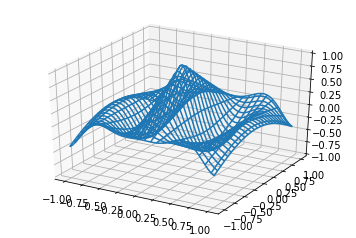

Average FPS: 9.689034


In [5]:
from __future__ import print_function

from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy as np
import time


def generate(X, Y, phi):
    '''
    Generates Z data for the points in the X, Y meshgrid and parameter phi.
    '''
    R = 1 - np.sqrt(X**2 + Y**2)
    return np.cos(2 * np.pi * X + phi) * R


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Make the X, Y meshgrid.
xs = np.linspace(-1, 1, 50)
ys = np.linspace(-1, 1, 50)
X, Y = np.meshgrid(xs, ys)

# Set the z axis limits so they aren't recalculated each frame.
ax.set_zlim(-1, 1)

# Begin plotting.
wframe = None
tstart = time.time()

for phi in np.linspace(0, 180. / np.pi, 100):
    # If a line collection is already remove it before drawing.
    if wframe:
        ax.collections.remove(wframe)

    # Plot the new wireframe and pause briefly before continuing.
    Z = generate(X, Y, phi)
    wframe = ax.plot_wireframe(X, Y, Z, rstride=2, cstride=2)
    
    plt.pause(.1)
plt.show()
print('Average FPS: %f' % (100 / (time.time() - tstart)))